In [162]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [180]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    }

data_dir = 'Canula'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

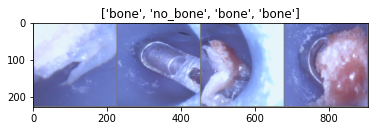

In [181]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [182]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [183]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [184]:
model_ft = models.resnet34()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [185]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9442 Acc: 0.5022
val Loss: 3.8216 Acc: 0.4750

Epoch 1/24
----------
train Loss: 0.6595 Acc: 0.6740
val Loss: 0.5694 Acc: 0.4750

Epoch 2/24
----------
train Loss: 0.7725 Acc: 0.6344
val Loss: 1.2398 Acc: 0.4750

Epoch 3/24
----------
train Loss: 0.8667 Acc: 0.6696
val Loss: 0.7555 Acc: 0.3000

Epoch 4/24
----------
train Loss: 0.5825 Acc: 0.6652
val Loss: 0.9844 Acc: 0.5250

Epoch 5/24
----------
train Loss: 0.5109 Acc: 0.7533
val Loss: 0.4785 Acc: 0.7250

Epoch 6/24
----------
train Loss: 0.5496 Acc: 0.7445
val Loss: 0.6576 Acc: 0.6750

Epoch 7/24
----------
train Loss: 0.4700 Acc: 0.7621
val Loss: 0.6644 Acc: 0.7500

Epoch 8/24
----------
train Loss: 0.4932 Acc: 0.7401
val Loss: 0.6323 Acc: 0.7500

Epoch 9/24
----------
train Loss: 0.5185 Acc: 0.7401
val Loss: 0.6519 Acc: 0.7000

Epoch 10/24
----------
train Loss: 0.5022 Acc: 0.7489
val Loss: 0.6861 Acc: 0.7500

Epoch 11/24
----------
train Loss: 0.4900 Acc: 0.7533
val Loss: 0.7246 Acc: 0.7500

Ep

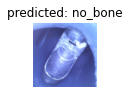

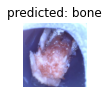

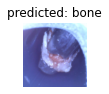

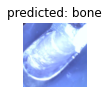

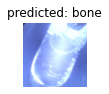

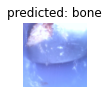

In [186]:
visualize_model(model_ft)

In [188]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [189]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6449 Acc: 0.6828
val Loss: 0.7108 Acc: 0.6250

Epoch 1/24
----------
train Loss: 0.5569 Acc: 0.7313
val Loss: 0.1656 Acc: 0.9750

Epoch 2/24
----------
train Loss: 0.4200 Acc: 0.8150
val Loss: 0.1312 Acc: 0.9750

Epoch 3/24
----------
train Loss: 0.5852 Acc: 0.7357
val Loss: 0.5214 Acc: 0.7000

Epoch 4/24
----------
train Loss: 0.3941 Acc: 0.8106
val Loss: 0.1176 Acc: 0.9750

Epoch 5/24
----------
train Loss: 0.4575 Acc: 0.8018
val Loss: 0.1807 Acc: 0.9500

Epoch 6/24
----------
train Loss: 0.4732 Acc: 0.8018
val Loss: 0.1747 Acc: 0.9500

Epoch 7/24
----------
train Loss: 0.4083 Acc: 0.8106
val Loss: 0.1644 Acc: 0.9250

Epoch 8/24
----------
train Loss: 0.4123 Acc: 0.8106
val Loss: 0.1628 Acc: 0.9500

Epoch 9/24
----------
train Loss: 0.4196 Acc: 0.7974
val Loss: 0.1311 Acc: 0.9500

Epoch 10/24
----------
train Loss: 0.4136 Acc: 0.7930
val Loss: 0.1269 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.4641 Acc: 0.7930
val Loss: 0.1525 Acc: 0.9750

Ep

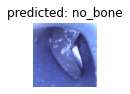

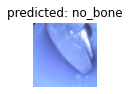

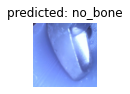

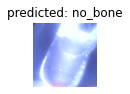

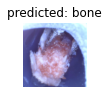

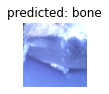

In [190]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [194]:
## test the model on test data

# get test data
test_dir = 'Canula/test/'
test_data = datasets.ImageFolder(test_dir, data_transforms['test'])

# get test data loader
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True, num_workers=4)


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    num_of_test_images = len(test_data)
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_conv(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy of the model on the {num_of_test_images} test images: {100 * correct / total} %')
# Save entire model
torch.save(model_conv, 'model_conv.pth')



Test Accuracy of the model on the 42 test images: 100.0 %


In [57]:
## Train the same model using tensorflow
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [2]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import numpy as np
import pathlib

# Using GPU
import os
import scipy.io as scpy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
# root_dir = 'C:/Users/101/repos/postural_sway_analysis/data/'

1 Physical GPUs, 1 Logical GPUs


In [3]:
train_data_dir = 'Canula/train/'
val_data_dir = 'Canula/val/'
test_data_dir = 'Canula/test/'
train_data_dir = pathlib.Path(train_data_dir)
image_count = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)


227


In [15]:
## Create a dataset
batch_size = 32
img_height = 224
img_width = 224

train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

## Concatenate train and validation and test data
train_ds = train_ds.concatenate(val_ds)
train_ds = train_ds.concatenate(test_ds)

## Convert the the data to x_train and y_train format 
x_train = []
y_train = []
for images, labels in train_ds:
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

## Create x_data and y_data and take everything from the x_train and y_train
## The shape of x_data is (number of images, 224, 224, 3) and y_data is (number of images, 1)
for i in range(1, x_train.shape[0]):
    x_train[i] = np.concatenate((x_train[i-1], x_train[i]), axis=0)
    y_train[i] = np.concatenate((y_train[i-1], y_train[i]), axis=0)
    x_data = x_train[-1]
    y_data = y_train[-1]

Found 227 files belonging to 2 classes.
Found 40 files belonging to 2 classes.
Found 42 files belonging to 2 classes.
(12,)
(12,)


/tmp/ipykernel_353677/1818766459.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(x_train)
/tmp/ipykernel_353677/1818766459.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array(y_train)


In [69]:
## Split the data into train, validation and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)
print(f"Training size : {x_train.shape}")
print(f"Validation size : {x_val.shape}")
print(f"Testing size : {x_test.shape}")
## Convert it to int8
x_train = x_train.astype(np.uint8)
x_val = x_val.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)
y_test = y_test.astype(np.uint8)


Training size : (222, 224, 224, 3)
Validation size : (40, 224, 224, 3)
Testing size : (47, 224, 224, 3)


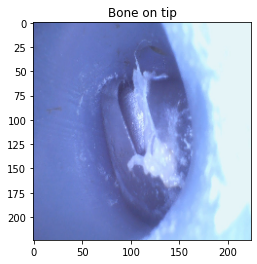

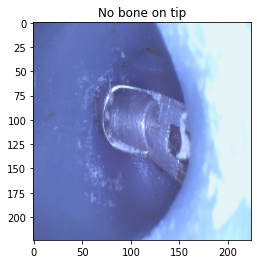

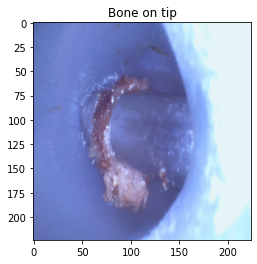

In [70]:
## Visualize 1 samples from training, validation and test data
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_data(x_data, y_data, num_of_samples=1):
    """
    Visualize the data
    """
    for i in range(num_of_samples):
        index = random.randint(0, len(x_data))
        image = x_data[index]
        label = y_data[index]
        plt.imshow(image)
        if label == 0:
            plt.title("Bone on tip")
        elif label == 1:
            plt.title("No bone on tip")
        plt.show()

visualize_data(x_train, y_train, num_of_samples=1)
visualize_data(x_val, y_val, num_of_samples=1)
visualize_data(x_test, y_test, num_of_samples=1)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 3)        0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 588)               0         
                                                                 
 dense_51 (Dense)            (None, 32)                18848     
                                                                 
 dense_52 (Dense)            (None, 8)                 264       
                                                                 
 dense_53 (Dense)            (None, 2)                 18        
                                                                 
Total params: 19,130
Trainable params: 19,130
Non-trainable params: 0
_________________________________________________

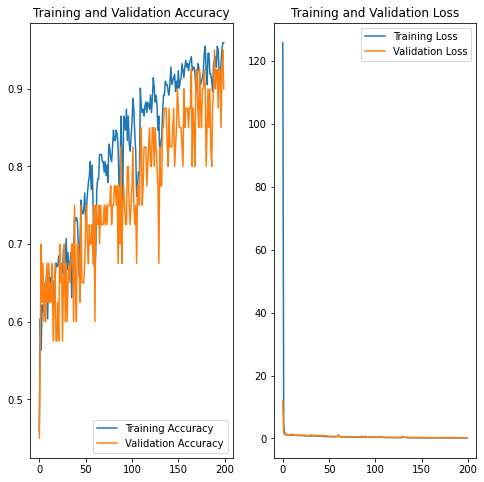

In [79]:
## Create the custom_model
## Fix seed for reproducibility
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

num_classes = 2

custom_model = models.Sequential()
custom_model.add(layers.InputLayer(input_shape=(img_height, img_width, 3)))
custom_model.add(layers.MaxPool2D(pool_size=16, strides=16, padding='valid'))
# custom_model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same'))
# custom_model.add(layers.MaxPool2D(pool_size=4, strides=2, padding='valid'))
# custom_model.add(layers.Conv2D(2, (3, 3), activation='relu', padding='same'))
custom_model.add(layers.Flatten())
custom_model.add(layers.Dense(32, activation='relu'))
custom_model.add(layers.Dense(8, activation='relu'))
custom_model.add(layers.Dense(2, activation='softmax'))

custom_model.summary()

## Compile and train the custom_model
custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


epochs=200
history = custom_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs
)

## Plot the training and validation accuracy/loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
## Evaluate the model
test_loss, test_acc = custom_model.evaluate(x_test,y_test, verbose=2)

2/2 - 0s - loss: 0.1978 - accuracy: 0.9362 - 14ms/epoch - 7ms/step


In [74]:
## Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(custom_model)
tflite_model = converter.convert()
## Save the model
with open('dense_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3ahqbd9j/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ahqbd9j/assets
2023-03-29 17:00:48.112595: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-29 17:00:48.136310: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3ahqbd9j
2023-03-29 17:00:48.142490: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 34904 microseconds.


In [75]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train.astype(np.float32)).batch(1).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
tflite_quant_model = converter.convert()
## Save the model
with open('dense_quantized.tflite', 'wb') as f:
    f.write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmp3wosj33c/assets


INFO:tensorflow:Assets written to: /tmp/tmp3wosj33c/assets
/home/veysiadn/anaconda3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-03-29 17:00:51.261196: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-29 17:00:51.281537: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3wosj33c
2023-03-29 17:00:51.286422: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: success: OK. Took 28402 microseconds.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type: FLOAT32


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dense_21 (Dense)            (None, 16)                1605648   
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 25,193,514
Trainable params: 1,605,802
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
7/7 [=================

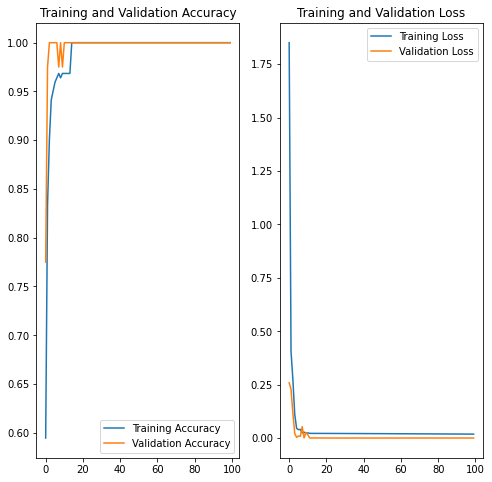

In [44]:
## Try pretrained resnet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = (img_height, img_width, 3)
base_model = ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create new model on top
model = tf.keras.Sequential([
    base_model,
    Flatten(),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

# Train the model
epochs=100
history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs=epochs
)


## Plot the training and validation accuracy/loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [46]:
model.evaluate(x_test, y_test, verbose=2)

2/2 - 0s - loss: 0.0678 - accuracy: 0.9787 - 275ms/epoch - 137ms/step


[0.06778442859649658, 0.978723406791687]

In [47]:
## Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

2/2 [==============================] - 0s 22ms/step
[[27  0]
 [ 1 19]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.95      0.97        20

    accuracy                           0.98        47
   macro avg       0.98      0.97      0.98        47
weighted avg       0.98      0.98      0.98        47

